In [88]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from PIL import Image

In [89]:
# Load MNIST dataset by torchvision.dataset
# mnist_train = datasets.MNIST('data/', train=True, download=True)  # 60000
# mnist_test = datasets.MNIST('data/', train=False, download=True)  # 10000

In [90]:
# Load MNIST dataset by mnist.npz
import numpy as np
# mnist = np.load('data/mnist.npz')  # [i for i in mnist.keys()]
# print("mnist keys: ", [i for i in mnist.keys()])  # ['x_test', 'x_train', 'y_train', 'y_test']
with np.load('data/mnist.npz') as data:
    train_examples = data['x_train']  # shape = (60000, 28, 28)
    train_labels = data['y_train']  # shape = (60000, )
    test_examples = data['x_test']  # shape = (10000, 28, 28)
    test_labels = data['y_test']  # shape = (10000, )

In [91]:
# 데이터셋이 0-1 사이의 값인지 / 0-255 사이의 값인지 확인
np.histogram(train_examples)

(array([38847859,   571880,   514157,   438029,   446644,   503214,
          469607,   518723,   611860,  4118027]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]))

In [92]:
# MNIST Normalization
mnist_mean = train_examples.mean()
mnist_std = train_examples.std()
print("mean: {}, std: {}".format(mnist_mean, mnist_std))

mean: 33.318421449829934, std: 78.56748998339798


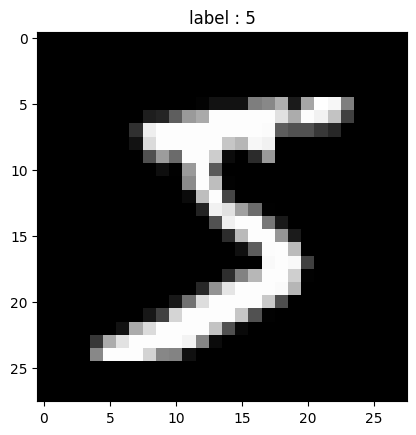

In [93]:
# Visualize MNIST sample
plt.imshow(train_examples[0], cmap='gray')
plt.title('label : %s' % train_labels[0])
plt.show()

In [94]:
# Configs
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.2
EPOCHS = 5

In [95]:
# Pytorch Dataset
from torch.utils.data import Dataset


class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.fromarray(image)

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [106]:
# Train MNIST dataset

train_transform = transforms.Compose([
    # transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mnist_mean], std=[mnist_std]),

    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mnist_mean], std=[mnist_std]),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

train_dataset = MnistDataset(train_examples, train_labels, transform=train_transform)
test_dataset = MnistDataset(test_examples, test_labels, transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1, shuffle=False, num_workers=2)

In [140]:
class MnistClassifier(torch.nn.Module):
    def __init__(self, input_size=(28, 28), num_classes=10, dropout_late=0.2):
        super(MnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')  # 28 28
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool2d = nn.MaxPool2d((2, 2))  #
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, 1, padding='same')
        self.bn3 = nn.BatchNorm2d(64)  # 원본: 128
        self.fc1 = nn.Linear(7*7*64, 64)  # 원본: 7*7*128
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout2d(dropout_late)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.maxpool2d(self.relu(self.bn1(self.conv1(x))))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool2d(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

In [141]:
model = MnistClassifier(dropout_late=DROPOUT_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [142]:
model.train()

MnistClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (relu): ReLU()
)

In [154]:
for epoch in range(EPOCHS):
    model.train()
    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Epoch {}/{} || Train Step : {} \\ \tLoss : {:3f}".format(epoch, EPOCHS, i, loss.item()))

    model.eval()
    count = 0
    for i, (image, label) in enumerate(test_loader):
        pred = model(image).argmax().item()
        if pred == label.item():
            count += 1
    print("Test Accuracy : {:3f}".format(count / len(test_loader)))


Epoch 0/5 || Train Step : 0	Loss : 0.421519
Epoch 0/5 || Train Step : 1000	Loss : 0.193332
Test Accuracy : 0.964100
Epoch 1/5 || Train Step : 0	Loss : 0.070521
Epoch 1/5 || Train Step : 1000	Loss : 0.124635


KeyboardInterrupt: 